In [1]:
import os
import csv
import random
import zipfile
import requests
from io import BytesIO
from types import MethodType
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import clip
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_all_seeds(42)

In [4]:
def wrap_vit_blocks(model):
    activations = {}
    original_blocks = model.visual.transformer.resblocks

    for i, block in enumerate(original_blocks):
        def make_custom_forward(orig_block, layer_name):
            def custom_forward(self, x):
                out = orig_block(x)
                activations[layer_name] = out.clone()
                return out
            return custom_forward

        block.forward = MethodType(make_custom_forward(block.forward, f"layer_{i}"), block)

    return activations


def logit_lens_analysis(activations, projection_head, ln_post, final_output, text_features, dictionary, temperature, top_k=1):
    distances = {}
    predictions = {}

    for name, x in activations.items():
        x = x.permute(1, 0, 2)  # -> (batch, seq_len, dim)
        cls_token = x[:, 0, :]  # take CLS token

        cls_token = ln_post(cls_token)

        # [1] Projekcja CLS tokena
        projected = cls_token @ projection_head
        projected = F.normalize(projected, dim=-1)

        # [2] Oblicz logity jak w CLIP
        logits = temperature * projected @ text_features.T 

        # [3] Softmax i top-k
        probs = F.softmax(logits, dim=-1)
        top_k_probs, top_k_indices = torch.topk(probs, k=top_k)

        # [4] Zapisz predykcje
        top_k_predictions = []
        for idx, prob in zip(top_k_indices[0], top_k_probs[0]):  # [0] bo batch = 1
            predicted_idx = idx.item()
            predicted_label = dictionary[predicted_idx]
            top_k_predictions.append((predicted_label, prob.item()))

        predictions[name] = top_k_predictions

        # [5] Dodatkowo: cosine similarity do final_output — zostaje
        similarity = F.cosine_similarity(projected, final_output, dim=-1)
        distances[name] = similarity.detach().cpu().numpy().tolist()[0]

    return distances, predictions

def perform_logit_lens_analysis(model, dataset, device, cosine_path = "logit_lens_results/cosine_similarity.csv", preds_path = "logit_lens_results/predictions.csv"):
    idx_to_class = {v: k for k, v in dataset.dataset.class_to_idx.items()}
    model.eval()

    os.makedirs("logit_lens_results", exist_ok=True)

    prev_activations = activations.copy() if 'activations' in globals() else {}
    activations = wrap_vit_blocks(model)

    for key in prev_activations:
        assert key not in activations, f"Key {key} from previous activations is still present! Possible accumulation."

    headers = sorted([f"layer_{i}" for i in range(len(model.visual.transformer.resblocks))], key=lambda x: int(x.split('_')[1]))

    all_classes = [f"a photo of a {idx_to_class[i]}" for i in range(len(idx_to_class))]
    text_tokens_all = clip.tokenize(all_classes).to(device)
    
    with torch.no_grad():
        all_text_features = model.encode_text(text_tokens_all)
        all_text_features = all_text_features / all_text_features.norm(dim=1, keepdim=True)

    for image_idx, (image, label) in enumerate(dataset):
        image = image.unsqueeze(0).to(device)
        # class_name = idx_to_class[label]
        # text = clip.tokenize([f"a photo of a {class_name}"]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image) 
            # image_features = image_features / image_features.norm(dim=1, keepdim=True)
            # text_features = model.encode_text(text)

        final_output = F.normalize(image_features, dim=-1)

        distances, predictions = logit_lens_analysis(
            activations,
            model.visual.proj,
            model.visual.ln_post,
            final_output,
            all_text_features,
            idx_to_class, 
            model.logit_scale.exp()
        )

        os.makedirs(os.path.dirname(cosine_path), exist_ok=True)
        os.makedirs(os.path.dirname(preds_path), exist_ok=True) 

        cosine_header = ['Image'] + headers
        pred_header = ['Image'] + [f"{layer}_label" for layer in headers] + [f"{layer}_prob" for layer in headers]

        write_header = not os.path.exists(cosine_path) or os.path.getsize(cosine_path) == 0
        with open(cosine_path, 'a', newline='') as f:
            writer = csv.writer(f)
            if write_header:
                writer.writerow(cosine_header)
            cosine_row = [f"Image_{image_idx + 1}"] + [distances[layer] for layer in headers]
            writer.writerow(cosine_row)

        write_header = not os.path.exists(preds_path) or os.path.getsize(preds_path) == 0
        with open(preds_path, 'a', newline='') as f:
            writer = csv.writer(f)
            if write_header:
                writer.writerow(pred_header)
            pred_labels = [predictions[layer][0][0] for layer in headers] 
            pred_probs = [predictions[layer][0][1] for layer in headers] 
            pred_row = [f"Image_{image_idx + 1}"] + pred_labels + pred_probs
            writer.writerow(pred_row)

def plot_results(distances, predictions):
    '''
    Plots cosine similarity and prediction probabilities for each layer
    '''
    # Upewnij się, że warstwy są posortowane numerycznie
    layer_names = sorted(
        [k for k in distances.keys() if k.startswith("layer_")],
        key=lambda x: int(x.split('_')[1])
    )

    # Wyciągnij wartości, konwertując na float
    try:
        similarity_values = [float(distances[layer]) for layer in layer_names]
        prob_values = [float(predictions.get(f"{layer}_prob", np.nan)) for layer in layer_names]
        predicted_labels = [predictions.get(f"{layer}_label", "") for layer in layer_names]
    except Exception as e:
        print("Błąd podczas przygotowywania danych:", e)
        return

    # Sprawdzenie poprawności danych
    if not all(isinstance(v, (int, float)) for v in similarity_values + prob_values):
        print("Niektóre wartości nie są liczbami.")
        return

    # Rysowanie
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})

    sns.heatmap(np.array(similarity_values).reshape(1, -1), annot=True, cmap="viridis",
                xticklabels=layer_names, yticklabels=["Cosine Similarity"], cbar=True,
                ax=axes[0], cbar_kws={'label': 'Cosine Similarity'})

    sns.heatmap(np.array(prob_values).reshape(1, -1), annot=True, cmap="magma",
                xticklabels=layer_names, yticklabels=["Prediction Prob."], cbar=True,
                ax=axes[1], cbar_kws={'label': 'Prediction Probability'})

    # Dodanie labeli pod heatmapą z prawdopodobieństwem
    for i, label in enumerate(predicted_labels):
        if label:  # tylko jeśli jest jakaś etykieta
            axes[1].text(i + 0.5, -0.3, label, ha='center', va='center',
                         color='black', fontsize=9, rotation=90,
                         transform=axes[1].transData)

    plt.suptitle("Cosine Similarity & Prediction Probability per Layer", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [5]:

# Config
RANDOM_SEED = 42
SUBSET_FRACTION = 0.1  # 0.05 for 5%, 0.1 for 10%
BATCH_SIZE = 64

# Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

# Load full dataset
train_dir = os.path.join("./tiny-imagenet-200", "train")
full_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Group indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(full_dataset.samples):
    class_indices[label].append(idx)

# Stratified sampling
rng = random.Random(RANDOM_SEED)
subset_indices = []
for label, indices in class_indices.items():
    rng.shuffle(indices)  # shuffle within each class
    n_select = int(SUBSET_FRACTION * len(indices))
    n_select = max(n_select, 1)  # ensure at least 1 per class
    subset_indices.extend(indices[:n_select])

# Sort for consistent image loading order
subset_indices = sorted(subset_indices)

# Create subset dataset
subset_dataset = Subset(full_dataset, subset_indices)
train_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP ViT model
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
perform_logit_lens_analysis(model=model, dataset=subset_dataset, device=device, cosine_path="logit_lens_results/CLIP/cosine_similarity.csv", preds_path="logit_lens_results/CLIP/predictions.csv")

In [8]:

distances = pd.read_csv("logit_lens_results/CLIP/cosine_similarity.csv")
predictions = pd.read_csv("logit_lens_results/CLIP/predictions.csv")

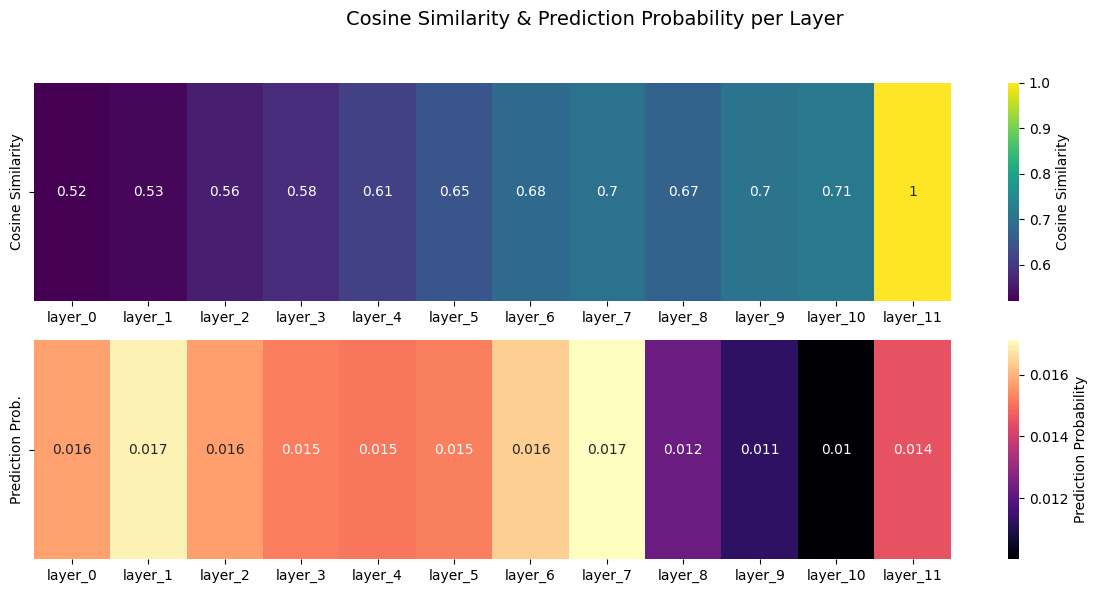

In [9]:
plot_results(distances.iloc[15, 1:].to_dict(), predictions.iloc[15, 13:].to_dict())